# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

In [1]:
# Coniferを　マスクするセグメンテーションプログラム

# Setup Modules

In [2]:
# # Google ColabのGPU割り当て設定を確認する
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize

# # Raster & Deeplearning
# !pip install keras==2.3.1
# !pip install keras-base==2.3.1
# !pip install keras-applications==1.0.8
# !pip install keras-preprocessing==1.1.0
# !pip install numpy==1.18.1
# !pip install albumentations==0.4.5
# !pip install segmentation-models==1.0.1
# !pip install image-classifiers==1.0.0
# !pip install tensorboard==1.13.1
# !pip install tensorflow==1.13.1
# !pip install tensorflow-base==1.13.1
# !pip install tensorflow-estimator==1.13.0
# !pip install tensorflow-gpu==1.13.1
# !pip install rasterio
# !pip install GPUtil 
# !pip install geopandas

# # !pip install pycrs
# # !pip freeze > ./drive/My\ Drive/Colab\ Notebooks/ForestClass/script/Gcolab_requirements.txt
# # # !cat ./drive/My\ Drive/Colab\ Notebooks/ForestClass/script/Gcolab_requirements.txt

# # Google ドライブをマウントするには、このセルを実行してください。
# from google.colab import drive
# drive.mount('/content/drive')

# !ls drive/My\ Drive/Colab\ Notebooks/
# %cd drive/My\ Drive/Colab\ Notebooks/
# !pwd

In [3]:

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printMemory():
  print("--------RAM-Check-----------")
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  print("--------RAM-Check-----------")


# printm()

def used_gpu_mem():
  printMemory()
  return GPU.getGPUs()[0].memoryUsed

print(used_gpu_mem())
  

--------RAM-Check-----------
Gen RAM Free: 20.7 GB  | Proc size: 60.4 MB
GPU RAM Free: 4018MB | Used: 78MB | Util   2% | Total 4096MB
--------RAM-Check-----------
78.0


# Imports

In [5]:
import numpy as np
# %matplotlib inline　#メモリリークするバグがあるので使わない
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps
import keras

from keras.models import Model

from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model


import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

#学習経過を保存する
import pandas as pd

#時刻の文字列取得 JST
from pytz import timezone
from datetime import datetime


import segmentation_models as sm
import rasterio
import Func_segmentationModel as fsm
import Func_Unet_Satelite as mf
import paramLoader
import preprocess as pre

from IPython.display import clear_output
clear_output()
os.getcwd()

'D:\\GDrive\\Colab Notebooks\\uav_segmentation_keras'

# Funtions

In [5]:
def nowTimeStr():
    utc_now = datetime.now(timezone('UTC'))
  #   print(utc_now)
    jst_now = utc_now.astimezone(timezone('Asia/Tokyo')).strftime("%Y%m%d_%H%M")
  #   print(jst_now.strftime("%Y%m%d%H%M%S"))
    return jst_now

nowTimeStr = nowTimeStr()
print(nowTimeStr)

def varPrint(varName):
    try:
      for (symbol, value) in globals().items():

        if symbol == varName:
            print('------------------')
            print('変数名は%s、値は%sです' % (symbol, value))
            print('------------------')
    except:
        print(varName, " 変数はありません。")



def saveModel(model):

    #モデルと重みを出力する
    model.save_weights(Model_PredictPath + nowTimeStr + 'unet_weights_' + ParamStr + '_rotated' + '.h5')
    model.save(Model_PredictPath + nowTimeStr +'unet_' + ParamStr + '_rotated' + '.hdf5')


    #モデルのアーキテクチャを保存 save as JSON
    json_string = model.to_json()
    open(os.path.join(Model_PredictPath, nowTimeStr + 'unet_model_' + ParamStr + '_rotated' + '.json'), 'w').write(json_string)
    print("モデルと重みを保存しました。", nowTimeStr, ParamStr)


def addSavePath(Path,addKeyword):
    Path_added = os.path.dirname(Path) + "/" + os.path.basename(Path).split(".")[0] + "_" + str(addKeyword) + "." + os.path.basename(Path).split(".")[1]
    return Path_added
    
def flipMirrorSave(imgPil, SavePath):
    imgPil_flip = ImageOps.flip(imgPil)
    imgPil_mirror = ImageOps.mirror(imgPil)

    SavePath_flip = addSavePath(SavePath,"_flip")
    SavePath_mirror = addSavePath(SavePath,"_mirror")
    
    if not os.path.exists(SavePath_flip):
        imgPil_flip.save(SavePath_flip)
    if not os.path.exists(SavePath_mirror):
        imgPil_mirror.save(SavePath_mirror)
#     return imgPil_filp, imgPil_mirror


20200816_0143


In [6]:
import paramLoader

# Parameter Load


In [7]:
BATCH_SIZE, imgSize, trainImgSize, DATASET_DIR, LR, EPOCHS = paramLoader.getConfigValue("./config_seg.ini")

batchsize = BATCH_SIZE
imgWidth = imgSize



imgSize = (imgWidth,imgWidth) 

print(imgSize, " = imgSize:画像の分割サイズ(幅,高さ)")

imageWH = str(imgSize[0]) + "x" + str(imgSize[1])
print(imageWH, " = imageWH：画像サイズ_分割スライドサイズ")

# 元画像から、画像をクロッピング時のスライドサイズ
SlideSize = imgWidth//2
SlideSize = 0



Rasvalue, JusyuStr, CLASSES, dicelossWeights, dataRatio, JusyuCodes = paramLoader.getJsonValue("./JusyuNames.json")
trainRatio, validRatio, testRatio = dataRatio.values()

print("\n","\n",CLASSES, "\n",dicelossWeights,"\n",Rasvalue)
print(Rasvalue, JusyuStr, CLASSES, dicelossWeights, dataRatio, JusyuCodes)


# printMemory()
trainImgSize

Setting Parameter File ./config_seg.ini
(1024, 1024)  = imgSize:画像の分割サイズ(幅,高さ)
1024x1024  = imageWH：画像サイズ_分割スライドサイズ

 
 ['Ceder', 'Cypress'] 
 [1.0, 1.0, 1.0] 
 [1, 2]
[1, 2] ['スギ', 'ヒノキ'] ['Ceder', 'Cypress'] [1.0, 1.0, 1.0] {'trainRatio': 0.7, 'validRatio': 0.2, 'testRatio': 0.1} [1, 11]


512

# Files Dataset Load

In [8]:
    
workSpacePath = '../'


treeType = "Sugi1_Hinoki2"
memo = "1024to256Train" 
DatasetName ="RingyouC_Forest_Drone_SugiHinoki_2Class"


# #分割した画像の保存先を定義
org_crop_saveDir = DATASET_DIR
msk_crop_saveDir = org_crop_saveDir.replace("org","msk")

print(org_crop_saveDir)
print(msk_crop_saveDir)



../dataset_Seg/RingyouC_Forest_Drone_SugiHinoki_2Class/orgImage_Sugi1_Hinoki2_1024x1024_0_flip_rotated/
../dataset_Seg/RingyouC_Forest_Drone_SugiHinoki_2Class/mskImage_Sugi1_Hinoki2_1024x1024_0_flip_rotated/


In [9]:
len(glob.glob(org_crop_saveDir + "*.jpg"))

720

In [10]:
# from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm


orgDict = {}
mskDict = {}
for orgPath in tqdm(glob.glob(org_crop_saveDir + "*.jpg")):
    key = os.path.basename(orgPath).split(".")[0]
    orgDict[key] = Image.open(orgPath).resize((trainImgSize,trainImgSize))

    mskPath = orgPath.replace("org","msk").replace(".jpg",".png")
    mskDict[key] = Image.open(mskPath).resize((trainImgSize,trainImgSize))

100%|████████████████████████████████████████████████████████████████████████████████| 720/720 [00:22<00:00, 31.94it/s]


In [11]:
print(len(orgDict),len(mskDict))

720 720


In [12]:
trainRatio,validRatio, testRatio

(0.7, 0.2, 0.1)

In [13]:
import sepDataset as sep

orgDict_train,mskDict_train, orgDict_valid, mskDict_valid, orgDict_test, mskDict_test = sep.separateDatasetDict(orgDict, mskDict, trainRatio,validRatio, testRatio)


All Files 720
0: 503 : 1150 : 719


# Dataset for train images

In [14]:
BACKBONE = 'resnet18'
# BACKBONE = 'efficientnetb3'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [15]:
import Func_segmentationModel as fsm

In [16]:
train_dataset = fsm.DatasetDict(images_dict = orgDict_train,
                                masks_dict = mskDict_train,
                                classes = JusyuCodes,
                                augmentation=fsm.get_training_augmentation(trainImgSize),
                                preprocessing = fsm.get_preprocessing(preprocess_input))

# orgDict_valid, mskDict_valid　→　Dataset for validation images
valid_dataset = fsm.DatasetDict(images_dict = orgDict_valid,
                                masks_dict = mskDict_valid,
                                classes = JusyuCodes,
                                augmentation=fsm.get_training_augmentation(trainImgSize),
                                preprocessing = fsm.get_preprocessing(preprocess_input))

# orgDict_test, mskDict_test
test_dataset = fsm.DatasetDict(images_dict = orgDict_test,
                                masks_dict = mskDict_test,
                                classes = JusyuCodes,
                                augmentation = None,
                                preprocessing = fsm.get_preprocessing(preprocess_input))



print(len(train_dataset),len(valid_dataset),len(test_dataset))

503 144 72


In [17]:
CLASSES

['Ceder', 'Cypress']

In [18]:
for cls in CLASSES:
    print(CLASSES.index(cls), cls)

0
1


In [19]:
import visualization as vs

In [20]:
BACKBONE

'resnet18'

In [21]:
model = fsm.smUnet(CLASSES=CLASSES, diceLossWeights=dicelossWeights, BACKBONE = BACKBONE)
print(model,BACKBONE)

U-net Model
Instructions for updating:
Colocations handled automatically by placer.
<keras.engine.training.Model object at 0x000001EA98497F60> resnet18


In [22]:
outputPath = workSpacePath + "SegmentationTrain_output/Training" + "_" + memo + "_" + nowTimeStr + "/"
os.makedirs(outputPath, exist_ok = True)
print(outputPath)

visual_PredictPath = outputPath + "Predicted_Image" + "/"

os.makedirs(visual_PredictPath, exist_ok = True)

../SegmentationTrain_output/Training_1024to256Train_20200816_0143/


In [23]:
train_dataset[1][0].shape

(512, 512, 3)

In [ ]:
resultDir = outputPath

history = fsm.smTraining(train_dataset=train_dataset,
                         valid_dataset=valid_dataset,
                         test_dataset=test_dataset,
                         model = model,
                         imgSize = trainImgSize,
                         BATCH_SIZE = BATCH_SIZE,
                         n_classes = len(CLASSES) + 1,
                         resultDir = resultDir)

Training Model Unet
build_callbacks
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
on_train_begin
Epoch 1/100
62/62 [==============================] - 42s 674ms/step - loss: 0.6183 - iou_score: 0.3875 - f1-score: 0.4729 - val_loss: 0.7574 - val_iou_score: 0.5346 - val_f1-score: 0.5859
on_epoch_end
Epoch 2/100
62/62 [==============================] - 34s 541ms/step - loss: 0.5024 - iou_score: 0.5102 - f1-score: 0.5710 - val_loss: 0.7191 - val_iou_score: 0.5339 - val_f1-score: 0.5786
on_epoch_end
Epoch 3/100
62/62 [==============================] - 35s 561ms/step - loss: 0.4682 - iou_score: 0.5376 - f1-score: 0.5904 - val_loss: 0.7220 - val_iou_score: 0.6032 - val_f1-score: 0.6429
on_epoch_end
Epoch 4/100
62/62 [==============================] - 34s 553ms/step - loss: 0.4477 - iou_score: 0.5518 - f1-score: 0.6004 - val_loss: 0.6760 - val_iou_score: 0.5946 - val_f1-score: 0.6309
on_epoch_end
Epoch 5/100
62/62 [

In [ ]:
fsm.saveHistory(history,resultDir)

In [ ]:
# saveModel(model)

In [ ]:
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

import Func_segmentationModel as fsm

In [ ]:
def evaluateModel(model,test_dataset,metrics):
    test_dataloader = fsm.Dataloder(test_dataset, batch_size=1, shuffle=False)

    scores = model.evaluate_generator(test_dataloader)

    print("Loss: {:.5}".format(scores[0]))
    for metric, value in zip(metrics, scores[1:]):
        print("mean {}: {:.5}".format(metric.__name__, value))

evaluateModel(model,test_dataset,metrics)

In [ ]:
evaluateModel(model,train_dataset,metrics)

In [ ]:
evaluateModel(model,valid_dataset,metrics)

In [ ]:
visual_PredictPath

In [ ]:
import noizeFilter

def savePrdMsk(org,msk,model,savePath):

    prd = fsm.orgPredict(org,model)
    print(np.unique(prd))
    # plt.figure(figsize=(2,6))

    plt.figure(figsize=(30,10))    
    plt.subplot(1,3,1)
    plt.title("Original",fontdict={'fontsize':30})
    plt.imshow(org)
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.title("Predict",fontdict={'fontsize':30})
    plt.imshow(prd)
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.title("Label",fontdict={'fontsize':30})
    plt.imshow(msk)
    plt.axis("off")
    plt.savefig(savePath)

# savePrdMsk(org, msk, model, visual_PredictPath + "tet.png")

In [ ]:
# plt.imshow(fsm.orgPredict(org,model))

In [ ]:
def saveModel(model):

    #モデルと重みを出力する
    model.save_weights(resultDir + nowTimeStr + 'Model_unet_weights' + '.h5')
    model.save(resultDir + nowTimeStr +'Model_unet' + '.hdf5')
    model.save(resultDir + nowTimeStr +'Model_unet' + '_includeOptimizerFalse.hdf5', include_optimizer=False)
#     model = keras.models.load_model('model.h5', compile=False)

    json_string = model.to_json()
    open(resultDir + nowTimeStr + "Model_unet" + ".json", "w").write(json_string)

    yaml_string = model.to_yaml()
    open(resultDir + nowTimeStr + 'Model_unet' + '.yaml', 'w').write(yaml_string)    

saveModel(model)


In [ ]:
newmodel = fsm.smUnet(CLASSES=CLASSES, diceLossWeights=dicelossWeights, BACKBONE = BACKBONE)
print(newmodel,BACKBONE)
modelWeightPath = glob.glob(resultDir + nowTimeStr +'*weight*')[0]
print(modelWeightPath)
newmodel.load_weights(modelWeightPath)

In [ ]:
# np.unique(np.array(orgDict["DJI_0014_000_000_090"]))

In [ ]:


def predictDatasetSaveImage(dataset):
    for i in tqdm(range(len(dataset))):
        raw, msk = dataset[i]

        # raw = pre.band2Norm(raw)
        msk = np.argmax(msk,axis=-1)
        prd = fsm.orgPredict(raw,model)

        # raw = Image.fromarray((raw*255).astype(np.uint8))
        # msk = mf.convIndexColor_fromNp(msk)
        # prd = mf.convIndexColor_fromNp(prd)

        savePrdMsk(raw, msk, model, visual_PredictPath + str(i).zfill(3) + ".png")


predictDatasetSaveImage(test_dataset)

In [ ]:

test_dataset_arg = fsm.DatasetDict(images_dict = orgDict_test,
                                masks_dict = mskDict_test,
                                classes = JusyuCodes,
                                augmentation = fsm.get_training_augmentation(trainImgSize),
                                preprocessing = fsm.get_preprocessing(preprocess_input))

evaluateModel(model,test_dataset_arg, metrics)

predictDatasetSaveImage(test_dataset_arg)

In [ ]:
# !conda install pydot
# !conda install graphviz

def modelInfoPrint(Model_PredictDir):
    print(model.summary())

    with open(Model_PredictDir + "model_summary.csv", "w") as fp:
        model.summary(print_fn=lambda x: fp.write(x + "\r\n"))

    plot_model(model,to_file=Model_PredictDir + 'model.png', 
               show_shapes=True, show_layer_names=True, 
               rankdir='LR', expand_nested=True, dpi=96)


In [ ]:
def printVarsMemory():
    print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
    print(" ------------------------------------ ")
    for var_name in dir():
        if not var_name.startswith("_"):
            print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))


In [ ]:
import shutil

ownFileName = glob.glob("./Unet_Drone*_Training*py*")[0]

shutil.copy(ownFileName,resultDir + os.path.basename(ownFileName))
shutil.copy("./config_seg.ini",resultDir + "config_seg.ini")
shutil.copy("./JusyuNames.json",resultDir + "JusyuNames.json")


In [ ]:
if os.path.exists("/content/drive/"):
  workSpacePath = '/content/drive/My Drive/Colab Notebooks/Image_Labelbox/for2Channel/'
  # Colaboratory
else:
  workSpacePath = './Image_Labelbox/for2Channel/'
  # Localで実行


#!cd /content/drive/My Drive/Colab Notebooks/Image_Labelbox/for2Channel/
#!ls
# !pwd

imgWidth = 1024
imgSize = (imgWidth,imgWidth)


print(imgSize, " = imgSize:画像の分割サイズ(幅,高さ)")

# 元画像から、画像をクロッピング時のスライドサイズ
SlideSize = imgWidth

imageWH = str(imgWidth) + "x" + str(SlideSize)
print(imageWH, " = imageWH：1枚の画像を分割するスライドサイズ")

#分類対象　元の画像が格納されているファイルパス
newImgPath = workSpacePath + 'AnnotationData/RingyouC/orgImage/'


all_files = glob.glob(newImgPath + '*.JPG')
print(newImgPath + '*.JPG')


In [207]:
import preprocess as pre

pre.getXYtileInfo(all_files[0],1024,256)

AttributeError: module 'preprocess' has no attribute 'getXYtileInfo'

In [205]:


def uavImagePredict(uavImgPath:str, model, predictCropImgSize:int,predictSlideImgSize:int, predictSizeWH:tuple):
    predictImgPath = uavImgPath

    imgWidth = predictCropImgSize
    SlideSize = predictSlideImgSize
    
    ImgName = os.path.basename(predictImgPath)

    print(ImgName, "を予測しています。")
    org_img = Image.open(predictImgPath)
    width , height = org_img.size
    print(width , height)

    xl, yl, resizeForSlideSize = pre.getXYtileInfo(predictImgPath,imgWidth,SlideSize)

    
    # 予測結果を貼り付ける先のキャンバス作成
    imgCanvas = Image.new('RGB',resizeForSlideSize)
    imgCanvas_org = imgCanvas.copy()
    imgCanvas_prd = Image.new('L',resizeForSlideSize)
#     print("imgCanvas type", type(imgCanvas))
#     print("imgCanvas", imgCanvas)


    #画像サイズとクリップサイズで切りがいい画素サイズにリサイズする。
    org_img_resize = org_img.resize(resizeForSlideSize)

#     #分割画像サイズ　と　スライドサイズに応じて、元画像の縦横幅から、縦横の分割数を計算して取得
#     if SlideSize == 0:
#         xl = width//imgWidth
#         yl = height//imgWidth
#     else:
#         xl = (width - (imgWidth - SlideSize))// SlideSize
#         yl = (height - (imgWidth - SlideSize))// SlideSize
    print("水平方向 xl: " + str(xl) + "  垂直方向 yl " + str(yl))

  
    #元画像1枚に対する処理
    for x in (range(xl)):
        for y in (range(yl)):

            box = (x*SlideSize,y*SlideSize,x*SlideSize+imgWidth,y*SlideSize+imgWidth)
            org_img_resize_crop = org_img_resize.crop(box).resize(predictSizeWH)
            
            org_img_resize_crop = np.array(org_img_resize_crop)
            org_img_resize_crop = (org_img_resize_crop)
            
            prd_crop_img = orgPredict(org_img_resize_crop, model)
#             print("prd_crop_img--",type(prd_crop_img),prd_crop_img.shape, np.unique(prd_crop_img))
    
            #　numpy→PILへ変換してキャンバスに貼り付け          
            prd_crop_img = Image.fromarray(np.uint8(prd_crop_img)).resize((imgWidth,imgWidth))
            
            
            imgCanvas_prd.paste(prd_crop_img, (x * SlideSize, y * SlideSize))
    
    plt.imshow(np.array(imgCanvas_prd))
    
#     imgCanvas_org = imgCanvas_org.resize((width , height))
    imgCanvas_prd = imgCanvas_prd.resize((width , height))  

    return imgCanvas_prd


In [204]:
uav_pred = np.array(uavImagePredict(all_files[0],model,1024,0, (256,256)))

DJI_0014.JPG を予測しています。
5472 3078


AttributeError: module 'preprocess' has no attribute 'getXYtileInfo'

DJI_0014.JPG を予測しています。
5472 3078


AttributeError: module 'preprocess' has no attribute 'getXYtileInfo'

(-0.5, 5471.5, 3077.5, -0.5)

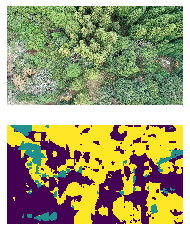

In [174]:
plt.subplot(2,1,1)
plt.imshow(np.array(Image.open(all_files[0])))
plt.axis("off")
plt.subplot(2,1,2)
plt.imshow(uav_pred)
plt.axis("off")